# Beam stability checks

CCOB requirements state that the beam repeatability must be ensured at the 0.2% level. Two checks are performed below on CCOB data taken with RTM-006 on TS8:

1. Stability checked using the photodiode mounted on the integrating sphere
2. Sanity check performed using image differences

In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import numpy as np
import yaml

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_ccob_config(config_file):
    """
    Loads ccob configuration (led, current, exp_time and position)
    from a config yaml file
    """
    config = yaml.load(open(config_file))
    if 'path' not in config.keys(): config['path'] = './'
    if 'led_name' not in config.keys(): config['led_name'] = '*'
    if 'current' not in config.keys(): config['current'] = '*'
    if 'exp_time' not in config.keys(): config['exp_time'] = '*'
    if 'xpos' not in config.keys(): config['xpos'] = '*'
    if 'ypos' not in config.keys(): config['ypos']= '*'
    
    return config


In [4]:
config = load_ccob_config('/home/combet/ccob-wb/ccob_config_RTM-006_scan.yaml')
led_names = ['uv', 'blue', 'red', 'nm750','nm850','nm960']
#config['path'] = '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob'

## 1. Stability check using the photodiode

Information on the properties of the CCOB (photodiode, temperatures) are recorded during the acquisition in a separate log file. Eventually this information must also be included in the header of the image fits files.

* 10 images x 9 sensors = 90 images have been taken with the ccob in the same configuration (current, exposure time).
* NB : the data for the infrared (nm960) LED was taken before the PD data acquisition was fixed.

In [12]:
acq_log={}
for led in led_names:
    acq_log[led] = os.path.join(config['path'],led+'/ccob_acquisition.log')
acq_log    

{'uv': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/uv/ccob_acquisition.log',
 'blue': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/blue/ccob_acquisition.log',
 'red': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/red/ccob_acquisition.log',
 'nm750': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm750/ccob_acquisition.log',
 'nm850': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm850/ccob_acquisition.log',
 'nm960': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm960/ccob_acquisition.log'}

In [13]:
def ccob_properties(acq_log_file):
    with open(acq_log_file,"r") as fi:
        PD_voltage = []
        LED_temp1 = []
        LED_temp2 = []
        sphere_temp = []
        board_temp = []
        position = []
        for ln in fi:
            if "Position" in ln:
                position.append(ln.split('=')[1])
            if "Photodiode Current" in ln:
                PD_voltage.append(float(ln.split('=')[1]))
            if "LED Temp1" in ln:
                LED_temp1.append(float(ln.split('=')[1]))
            if "LED Temp2" in ln:
                LED_temp2.append(float(ln.split('=')[1]))
            if "Sphere temperature" in ln:
                sphere_temp.append(float(ln.split('=')[1]))
            if "Board temperature" in ln:
                board_temp.append(float(ln.split('=')[1]))
    return PD_voltage, LED_temp1, LED_temp2, sphere_temp, board_temp, position

### Read in CCOB properties and perform linear fits

In [15]:
fit_PD = {}
fit_temp1 = {}
fit_temp2 = {}
fit_sphere = {}
PD_voltage = {}
LED_temp1 = {}
LED_temp2 = {}
sphere_temp = {}
board_temp = {}
print('PD_voltage mean(relative difference):')
for led in led_names:
    pd, temp1, temp2, temp3, temp4, pos = ccob_properties(acq_log[led])
    PD_voltage[led] = (np.array(pd)-pd[0])*100/pd[0]
    LED_temp1[led] = temp1
    LED_temp2[led] = temp2
    sphere_temp[led] = temp3
    board_temp[led] = temp4
    print(led, min(pd),max(pd))
    
    x = np.arange(len(PD_voltage[led]))
    fit_coeff = np.polyfit(x,PD_voltage[led],1.)
    fit_PD[led] = fit_coeff[1] + fit_coeff[0]*x
    fit_coeff = np.polyfit(x,LED_temp1[led],1.)
    fit_temp1[led] = fit_coeff[1] + fit_coeff[0]*x
    fit_coeff = np.polyfit(x,LED_temp2[led],1.)
    fit_temp2[led] = fit_coeff[1] + fit_coeff[0]*x
    fit_coeff = np.polyfit(x,sphere_temp[led],1.)
    fit_sphere[led] = fit_coeff[1] + fit_coeff[0]*x
    print(led + ' {:.5f}'.format(np.mean(PD_voltage[led]))+'%')

PD_voltage mean(relative difference):
uv 0.219625 0.220884
uv 0.22155%
blue 0.18773 0.187876
blue 0.04501%
red 0.208728 0.208857
red 0.02276%
nm750 0.236174 0.23659
nm750 0.13630%
nm850 0.238702 0.238893
nm850 0.05236%
nm960 0.36813 0.36813
nm960 0.00000%


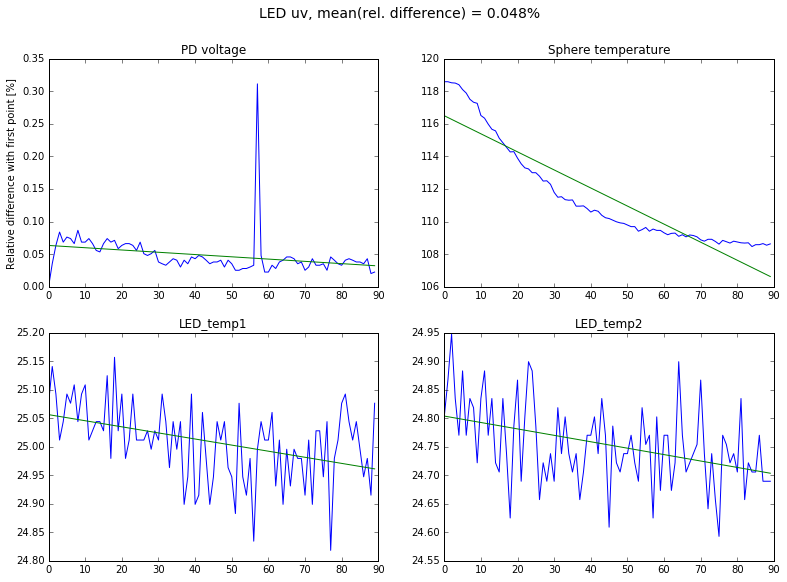

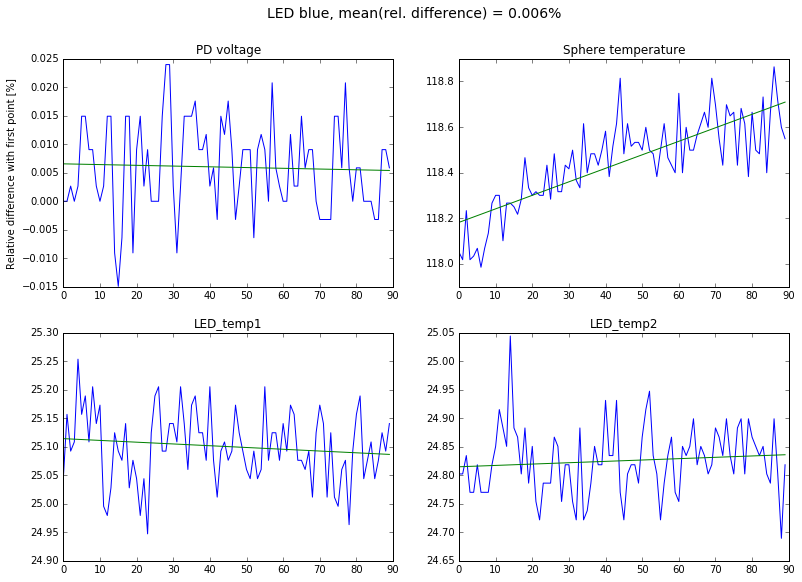

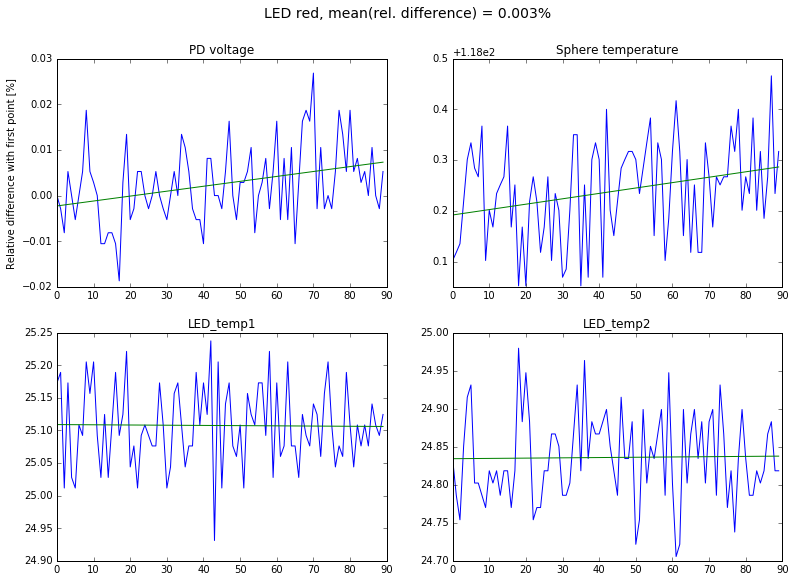

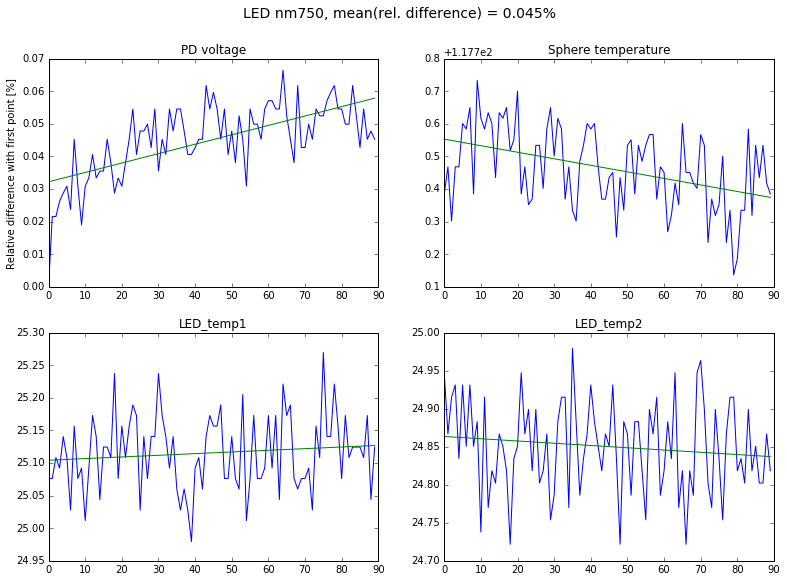

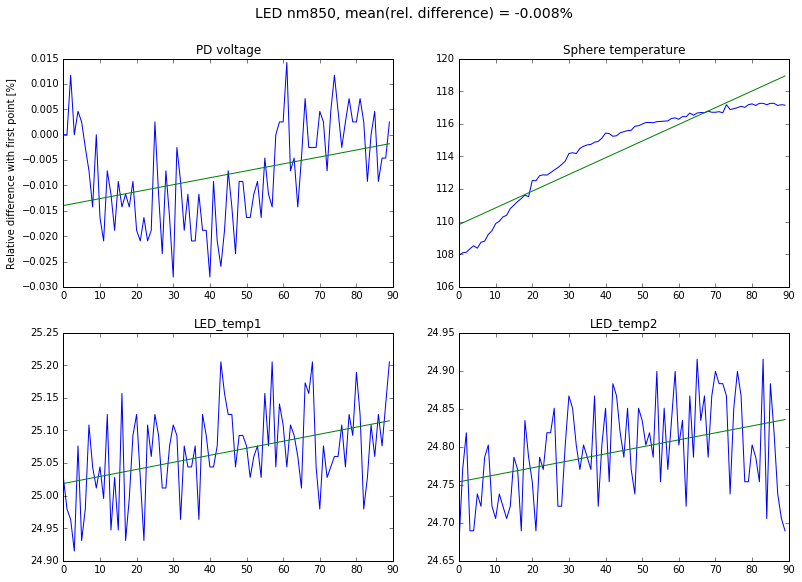

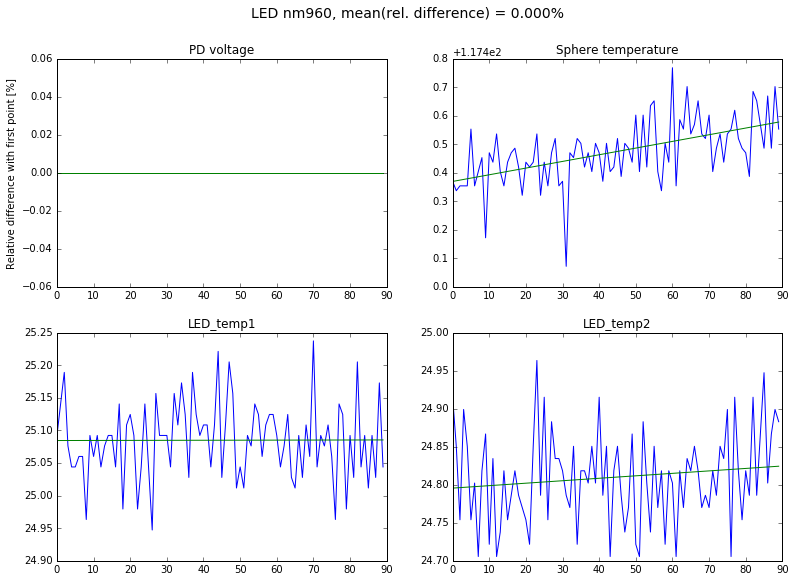

In [142]:
for led in led_names:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,9))
    axes[0][0].plot(x,PD_voltage[led])
    axes[0][0].plot(x,fit_PD[led])
    axes[0][0].set_title('PD voltage')
    axes[0][0].set_ylabel('Relative difference with first point [%]')
    axes[0][1].plot(x,sphere_temp[led])
    axes[0][1].plot(x,fit_sphere[led])
    axes[0][1].set_title('Sphere temperature')
    axes[1][0].plot(x,LED_temp1[led])
    axes[1][0].plot(x,fit_temp1[led])
    axes[1][0].set_title('LED_temp1')
    axes[1][1].plot(x,LED_temp2[led])
    axes[1][1].plot(x,fit_temp2[led])
    axes[1][1].set_title('LED_temp2')
    title = 'LED '+led+', mean(rel. difference) = '+'{:.3f}'.format(np.mean(PD_voltage[led]))+'%'
    fig.suptitle(title, size=14)
    fig.savefig(os.path.join(config['tmp_dir'],'CCOB_stability_'+led+'.png'))


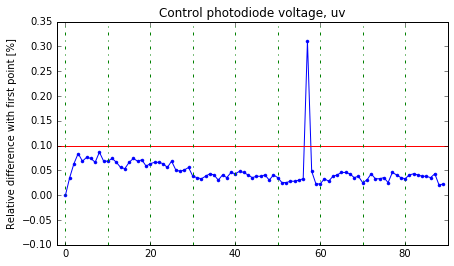

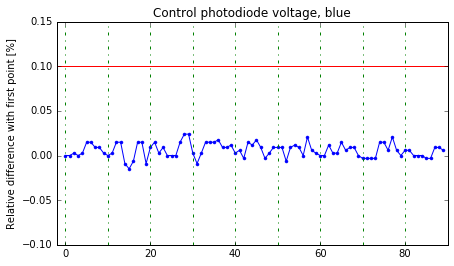

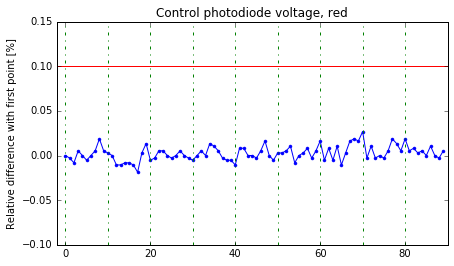

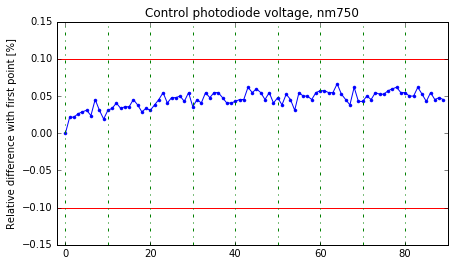

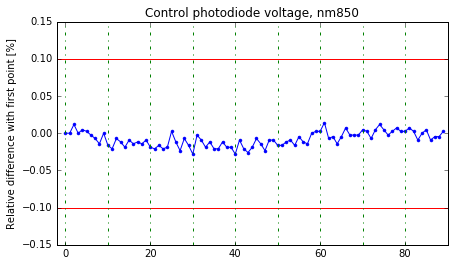

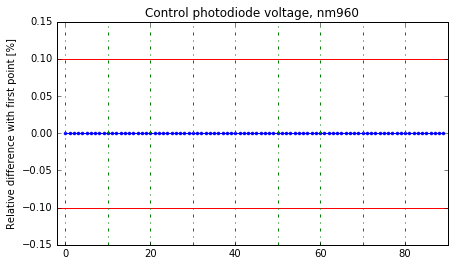

In [152]:
for led in led_names:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
    ax.plot(x,PD_voltage[led], marker='.')
    ax.axhline(0.1, color='red', linestyle='-')
    ax.axhline(-0.1, color='red', linestyle='-')
    ax.set_title('Control photodiode voltage, '+led)
    ax.set_ylabel('Relative difference with first point [%]')
    ax.set_xlim([-2,90])
    for i in np.arange(9):
        ax.axvline(i*10, color='g', linestyle='-.')
    fig.savefig(os.path.join(config['tmp_dir'],'CCOB_PD_stability_'+led+'.png'))


### Example of PD correction factor to apply to the data

In [9]:
pd, temp1, temp2, temp3, temp4, pos = ccob_properties(acq_log['uv'])
fact = ((np.array(pd) - pd[0])[0:10]/pd[0])  # S02
print fact
print 1./(1.+fact[7])/(1.+fact[0]) # correction factor to go from image 8 to image 1

[ 0.          0.00035442  0.00063615  0.00084062  0.00068613  0.00076338
  0.00074066  0.00066341  0.00086789  0.00068613]
0.99933702962


## 2. Stability check using image difference

10 images per sensor have been successively taken, with the CCOB in the same configuration. For a given sensor, the residuals between the 10 images should average to zero and be compatible with the expected noise level.

In [4]:
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft

In [5]:
def gains(eotest_results_file):
    """
    Extract Fe55 gains from the results file of some eo testing.
    """
    results = sensorTest.EOTestResults(eotest_results_file)
    return {amp: gain for amp, gain in zip(results['AMP'], results['GAIN'])}

def define_ccd_pos(ccd_pos_dict, raft_name, slot_names, xpos, ypos):
    ccd_pos_dict[raft_name] = {slot:[xpos[i],ypos[i]] for i,slot in enumerate(slot_names)}
    
def find_files(config, slot='*'):
    f_pattern = os.path.join(config['path'], slot+'*' + config['led_name'] + '*'
                             + config['current'] + '*' + config['exp_time'] + '*'
                             + config['xpos'] + '*' + config['ypos'] + '*')
    return glob.glob(f_pattern)
    

In [6]:
xpos = [253.0, 253.0, 253.0, 295.0, 295.0, 295.0, 337.0, 337.0, 337.0]
ypos = [237.0, 195.0, 153.0, 237.0, 195.0, 153.0, 237.0, 195.0, 153.0]
slot_names=['00','01','02','10','11','12','20','21','22']
ccd_pos_dict={}
define_ccd_pos(ccd_pos_dict, 'RTM-006', slot_names, xpos, ypos)

In [7]:
ccd_dict={}
gains_dict = {}
config = load_ccob_config('/home/combet/ccob-wb/ccob_config_RTM-006.yaml')
config['xpos'] = '*'
config['ypos'] = '*'
config['led_name'] = 'nm960'
config['path'] = os.path.join(config['path'],config['led_name'])
for slot in slot_names:
    f_list = []
    file_list=sorted(find_files(config,slot))
    xpos = str(ccd_pos_dict['RTM-006'][slot][0])
    ypos = str(ccd_pos_dict['RTM-006'][slot][1])
    pattern=slot+'_CCOB_'+config['led_name']+'_x'+xpos+'_y'+ypos
    for f in file_list:
        flag = pattern in f  
        if flag : f_list.append(f)
    ccd_dict[slot] = f_list    
    
    tmp = sensorTest.MaskedCCD(f_list[0])
    eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(tmp.md('LSST_NUM')))
    gains_dict[slot] = gains(eotest_results_file)   
    
print(ccd_dict['11'])


['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215617.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215626.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215635.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215644.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215652.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215701.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215710.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215718.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM

### For each slot of the raft, performs the difference between the 1st and the 7th image centered on the slot

Histogram of the residuals are plotted for each slot and LED. 

In [8]:
template_image = os.path.join(config['tmp_dir'], '20_corr_mean_beam_image_RTM-006.fits')

slot_names=['00','01','02','10','11','12','20','21','22']
diff = {}
im_ref = {}
for slot in slot_names:
    diff[slot] = {}
    im_ref[slot] = {}
    image_ref = {}
    for i,f in enumerate([ccd_dict[slot][0],ccd_dict[slot][7]]):
        print(i, f)
        fname = os.path.basename(f)
        ccd_data = sensorTest.MaskedCCD(f)
        image = {}
        if i == 0:
            for amp in ccd_data:
                image_ref[amp] = ccd_data.unbiased_and_trimmed_image(amp)
                image_ref[amp] *= gains_dict[slot][amp]
                diff[slot][i] = image_ref[amp].getArrays()[0].flatten() if amp==1 else np.append(diff[slot][i],image_ref[amp].getArrays()[0].flatten())
        else:
            for amp in ccd_data:
                image[amp] = ccd_data.unbiased_and_trimmed_image(amp)
                image[amp] *= gains_dict[slot][amp]
#                image[amp] *= 0.997  # PD correction factor
                image[amp] -= image_ref[amp]
                diff[slot][i] = image[amp].getArrays()[0].flatten() if amp==1 else np.append(diff[slot][i],image[amp].getArrays()[0].flatten())


0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215245.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215346.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215104.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215207.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420214920.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420215021.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215756.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215900.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180

In [9]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

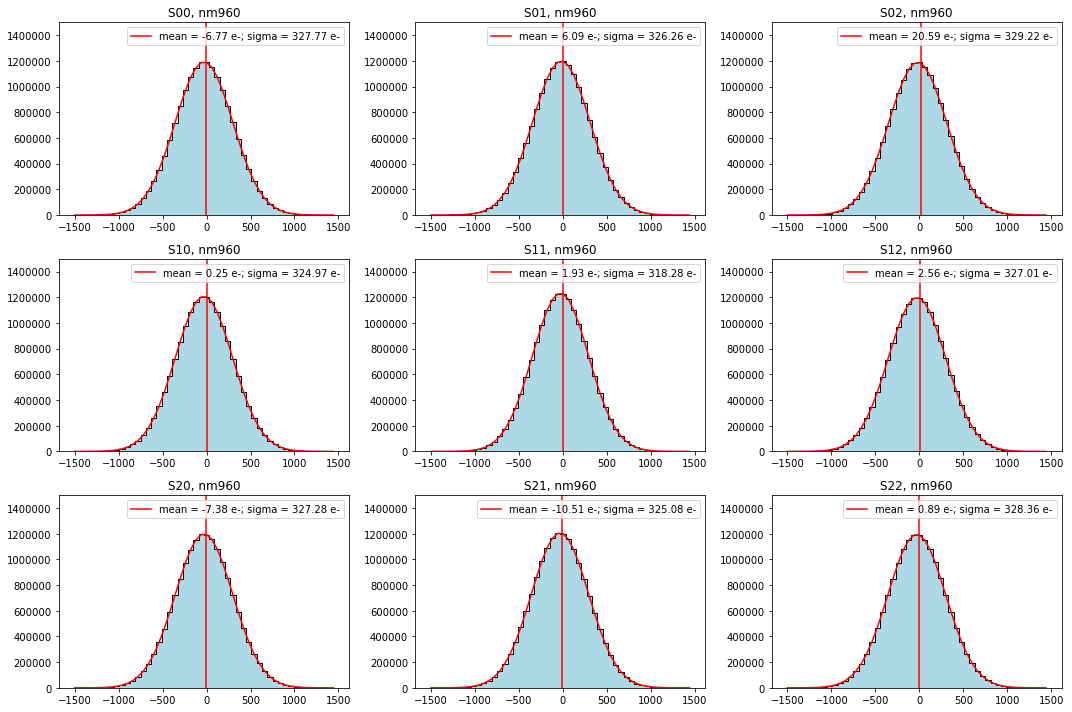

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
nbins = 50
for i,slot in enumerate(slot_names): 
    j,k = divmod(i,3)
    res = axes[j][k].hist(diff[slot][1], range=(-1500,1500), bins=nbins, align="left", edgecolor='black', color='lightblue',histtype= "stepfilled")
    popt,pcov = curve_fit(gaus,res[1][0:nbins],res[0])
#    label = "mean = "+"{:.2f}".format(popt[1])+ " e-; sigma = "+"{:.2f}".format(popt[2])+" e-"
    label = "mean = "+"{:.2f}".format(np.mean(diff[slot][1]))+ " e-; sigma = "+"{:.2f}".format(popt[2])+" e-"
    axes[j][k].plot(res[1][0:nbins],gaus(res[1][0:nbins], *popt), label=label, color='red')
#    axes[j][k].axvline(popt[1], color='r')    
    axes[j][k].axvline(np.mean(diff[slot][1]), color='r')    
    axes[j][k].set_ylim((0,1500000))
    axes[j][k].set_title("S"+slot+", "+config['led_name'])
    axes[j][k].legend()
fig.tight_layout()
fig.savefig(os.path.join(config['tmp_dir'],'CCOB_stability_img_diff2_'+config['led_name']+'.png'))

In [11]:
#template_image = os.path.join(config['tmp_dir'], '20_corr_mean_beam_image_RTM-006.fits')

slot_names=['00','01','02','10','11','12','20','21','22']
for slot in slot_names:
    image_ref = {}
    for i,f in enumerate([ccd_dict[slot][0],ccd_dict[slot][7]]):
        print(i, f)
        template_image = f
        fname = os.path.basename(f)
        ccd_data = sensorTest.MaskedCCD(f)
        image = {}
        if i == 0:
            for amp in ccd_data:
                image_ref[amp] = ccd_data.bias_subtracted_image(amp)
                image_ref[amp] *= gains_dict[slot][amp]
            imutils.writeFits({amp: image_ref[amp].getImage() for amp in ccd_data}, 
                      os.path.join(config['tmp_dir'],'image_ref_'+slot+'_'+config['led_name']+'.fits'), template_image)               
        else:
            for amp in ccd_data:
                image[amp] = ccd_data.bias_subtracted_image(amp)
                image[amp] *= gains_dict[slot][amp]
                image[amp] -= image_ref[amp]                       
            imutils.writeFits({amp: image[amp].getImage() for amp in ccd_data}, 
                      os.path.join(config['tmp_dir'],'image_diff_'+slot+'_'+config['led_name']+'.fits'), template_image)               

0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215245.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215346.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215104.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215207.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420214920.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420215021.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215756.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215900.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180

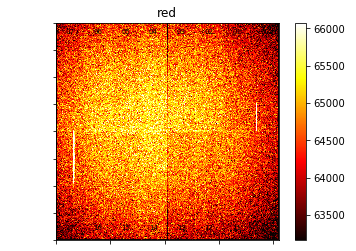

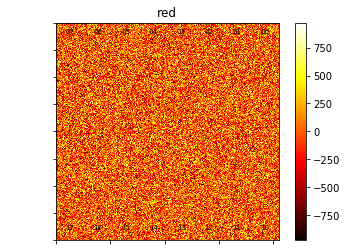

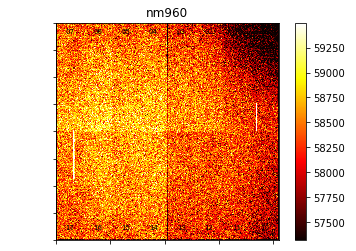

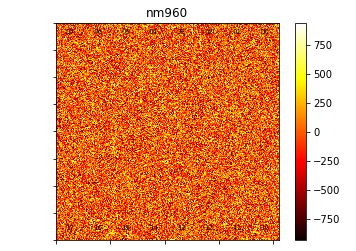

In [12]:
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_ref_11_red.fits'), title='red', nsig=2.5)
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_diff_11_red.fits'), title='red', nsig=3)

sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_ref_11_nm960.fits'), title='nm960', nsig=2.5)
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_diff_11_nm960.fits'), title='nm960', nsig=3)